In [1]:
from src.utils import interpolate_to_percentage, set_axes_equal
import matplotlib.pyplot as plt
import h5py
import numpy as np
np.set_printoptions(precision=3, suppress=True)
%matplotlib widget

import cv2
import mediapy

from scipy.spatial.distance import directed_hausdorff

import tikzplotlib

In [2]:
def get_positions(path):
    f = h5py.File(path,'r')
    poses = np.array(f['pose_values'])
    return poses[:,:3,3]*1000

In [3]:
slides_lab = [
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_124925_LAB_with_tracking/slide1.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_124925_LAB_with_tracking/slide2.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_124925_LAB_with_tracking/slide3.h5")
]

slides_vicon = [
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_144414_VICON_with_tracking/slide1.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_144414_VICON_with_tracking/slide2.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_144414_VICON_with_tracking/slide3.h5")
]

slides_lab_large = [
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_171427_LAB_LARGE_with_tracking1/slide1.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_171427_LAB_LARGE_with_tracking1/slide2.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240626_171427_LAB_LARGE_with_tracking1/slide3.h5")
]

slides_kitchen = [
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240627_152058_KITCHEN_with_tracking/slide1.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240627_152058_KITCHEN_with_tracking/slide2.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240627_152058_KITCHEN_with_tracking/slide3.h5")
]

slides_outside = [
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240627_162924_OUTSIDE_with_tracking/slide1.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240627_162924_OUTSIDE_with_tracking/slide2.h5"),
    get_positions("/Users/jannik/Repos/demonstration-interface/data/session_20240627_162924_OUTSIDE_with_tracking/slide3.h5")
]

In [4]:
# GROUND TRUTH
increments = 1000
z_up = np.linspace(0, 300, increments)
z_down = np.linspace(300, 0, increments)
z_trajectory = np.concatenate((z_up, z_down))
x_trajectory = np.zeros_like(z_trajectory)
y_trajectory = np.zeros_like(z_trajectory)
ground_truth = np.vstack((x_trajectory, y_trajectory, z_trajectory)).T

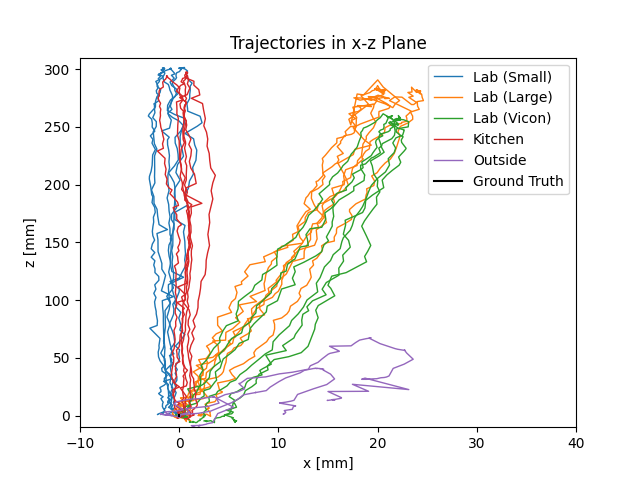

In [5]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ['Lab (Small)', 'Lab (Large)', 'Lab (Vicon)', 'Kitchen', 'Outside']
slides = [slides_lab, slides_lab_large, slides_vicon, slides_kitchen, slides_outside]
    
plt.figure()

for i, env in enumerate(slides):
    for j, slide in enumerate(env):
        if j % 3 == 0:
            plt.plot(slide[:,0],slide[:,2],  linewidth=1, color=colors[i], label=labels[i])
        else:
            plt.plot(slide[:,0],slide[:,2],  linewidth=1, color=colors[i], label='_no_legend_')
plt.plot(ground_truth[:,0],ground_truth[:,2], color='black', label="Ground Truth")
plt.xlim(-10, 40)
plt.ylim(-10, 310)
plt.xlabel('x [mm]')
plt.ylabel('z [mm]')
plt.title('Trajectories in x-z Plane')
plt.legend()
# plt.show()

tikzplotlib.clean_figure()
tikzplotlib.save("trajectories.tex")

In [6]:
print(tikzplotlib.Flavors.latex.preamble())


\documentclass{standalone}
\usepackage[utf8]{inputenc}
\usepackage{pgfplots}
\DeclareUnicodeCharacter{2212}{−}
\usepgfplotslibrary{groupplots,dateplot}
\usetikzlibrary{patterns,shapes.arrows}
\pgfplotsset{compat=newest}



In [7]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')    
# ax.set_box_aspect([1.0, 1.0, 1.0])

# ax.plot(slides_lab[0][:, 0], slides_lab[0][:, 1], slides_lab[0][:, 2], '-', c="red", label='Trajectory')
# ax.plot(slides_vicon[0][:, 0], slides_vicon[0][:, 1], slides_vicon[0][:, 2], '-', c="blue", label='Trajectory')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.grid(True)
# ax.view_init(elev=-45, azim=0, roll=0)
# set_axes_equal(ax)
# plt.show()

In [8]:
# Calculate the directed Hausdorff distance
# d_hausdorff_1_to_2 = directed_hausdorff(poses[:,:3,3], ground_truth)[0]
# d_hausdorff_2_to_1 = directed_hausdorff(ground_truth, poses[:,:3,3])[0]

# # Print the directed Hausdorff distances
# print(f"The directed Hausdorff distance from ground_truth to poses is: {d_hausdorff_1_to_2:.2f}mm")
# print(f"The directed Hausdorff distance from poses to ground_truth is: {d_hausdorff_2_to_1:.2f}mm")

In [9]:
def calculate_point_to_curve(path, ground_truth):
    def euclidean_distance(point1, point2):
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    errors = []

    for measured_point in path:
        closest_distance = float('inf')
        for ground_truth_point in ground_truth:
            distance = euclidean_distance(measured_point, ground_truth_point)
            if distance < closest_distance:
                closest_distance = distance
        errors.append(closest_distance)
    
    return interpolate_to_percentage(errors)

def calculate_stats(paths, ground_truth):
    errors = []
    for path in paths:
        errors.append(calculate_point_to_curve(path, ground_truth))
    errors = np.array(errors)
    mean_error = np.mean(errors, axis=0)
    min_error = np.min(errors, axis=0)
    max_error = np.max(errors, axis=0)
    return mean_error, min_error, max_error

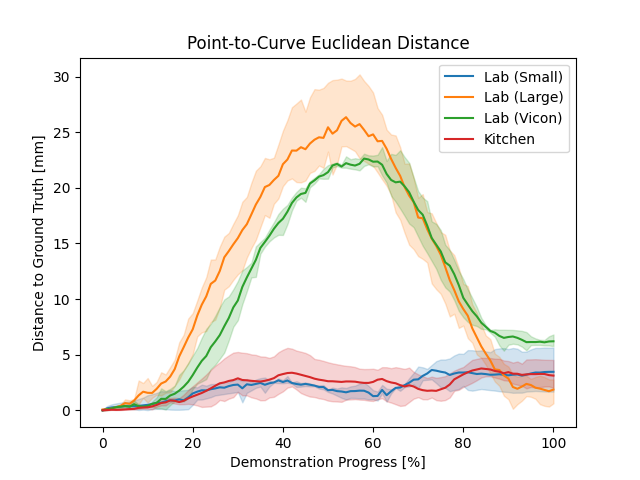

In [10]:
distance_stats = [calculate_stats(sld, ground_truth) for sld in slides]
    
plt.figure()
plt.title("Point-to-Curve Euclidean Distance")
plt.xlabel('Demonstration Progress [%]')
plt.ylabel('Distance to Ground Truth [mm]')
for i, stats in enumerate(distance_stats[:-1]):
    plt.plot(stats[0], color=colors[i], label=labels[i])
    plt.fill_between(np.linspace(0, 100, len(stats[0])), stats[1], stats[2], alpha=0.2, color=colors[i])
plt.legend()

tikzplotlib.clean_figure()
tikzplotlib.save("distances.tex")
# plt.show()

In [11]:
def fit_line_3d(points):
    # Center the data
    mean_point = points.mean(axis=0)
    centered_points = points - mean_point

    # Perform SVD
    _, _, vh = np.linalg.svd(centered_points)

    # The direction of the line is given by the first principal component
    line_direction = vh[0]

    # The point on the line can be the mean of the points
    line_point = mean_point

    return line_point, line_direction

def calculate_error(points, line_point, line_direction):   
    # Normalize the direction vector
    line_direction = line_direction / np.linalg.norm(line_direction)

    # Calculate the projection of each point onto the line
    projections = line_point + np.dot(points - line_point, line_direction)[:, np.newaxis] * line_direction

    # Calculate the distance from each point to its projection
    distances = np.linalg.norm(points - projections, axis=1)

    # Calculate total error and mean squared error
    total_error = np.sum(distances)
    mean_squared_error = np.mean(distances ** 2)

    return distances, total_error, mean_squared_error


In [12]:
line_point, line_direction = fit_line_3d(slides_vicon[1])

In [13]:
def get_example_tracking_images(path):
    f = h5py.File(path,'r')
    tracking_images = np.array(f['tracker_images'])
    images_converted = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in tracking_images])
   
    return np.array([cv2.rotate(image, cv2.ROTATE_180) for image in images_converted]) 

lab_images = get_example_tracking_images("/Users/jannik/Repos/demonstration-interface/data/session_20240626_124925_LAB_with_tracking/slide1.h5")
vicon_images = get_example_tracking_images("/Users/jannik/Repos/demonstration-interface/data/session_20240626_144414_VICON_with_tracking/slide1.h5")
lab_large_images = get_example_tracking_images("/Users/jannik/Repos/demonstration-interface/data/session_20240626_171427_LAB_LARGE_with_tracking1/slide1.h5")
kitchen_images = get_example_tracking_images("/Users/jannik/Repos/demonstration-interface/data/session_20240627_152058_KITCHEN_with_tracking/slide1.h5")
outside_images = get_example_tracking_images("/Users/jannik/Repos/demonstration-interface/data/session_20240627_162924_OUTSIDE_with_tracking/slide1.h5")


In [14]:
images = {
    'lab-small': lab_images[0],
    'vicon': vicon_images[0],
    'lab-large': lab_large_images[0],
    'kitchen': kitchen_images[0],
    'outside': outside_images[0]
}


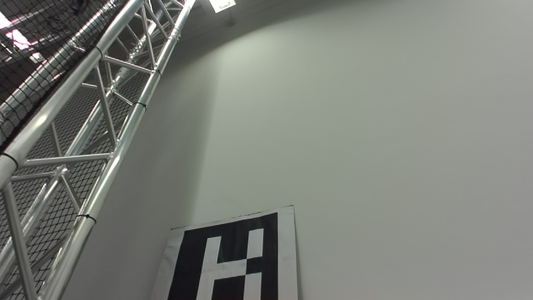
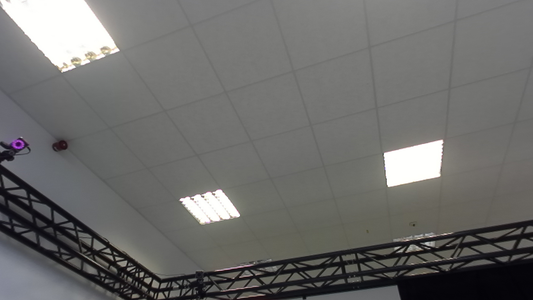
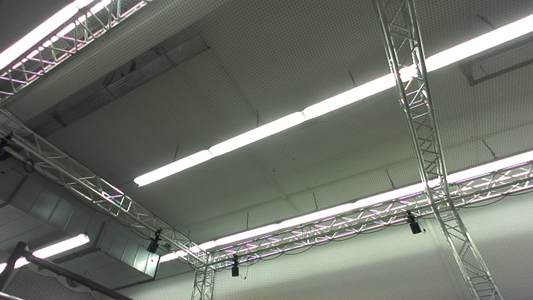
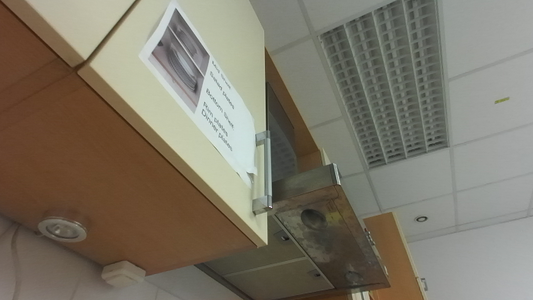
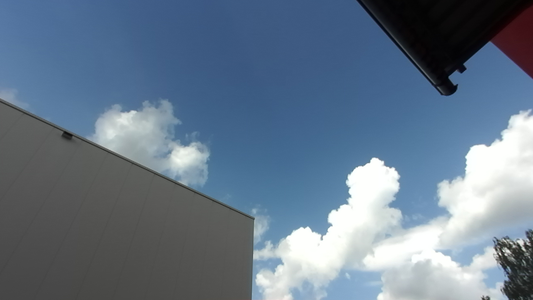

In [15]:
mediapy.show_images(images, columns=2, height=300)
for key, value in images.items():
    mediapy.write_image(f"images/{key}_tracker.jpg", value)

In [16]:
# fig, ax = plt.subplots()
# ax.scatter(slides_vicon[1][:,0], slides_vicon[1][:,2], label='Data points', marker=".")

# t = np.linspace(-200, 200, 100)
# line = line_point + t[:, np.newaxis] * line_direction

# ax.plot(line[:, 0], line[:, 2], color='red', label='Ground Truth')
# ax.set_xlabel('X')
# ax.set_ylabel('Z')
# ax.set_xlim(-100, 100)
# ax.legend()
# plt.show()

In [17]:
# distances, total_error, mean_squared_error = calculate_error(slides_vicon[1], line_point, line_direction)

In [18]:
# plt.figure()
# plt.plot(interpolate_to_percentage(distances))
# plt.xlabel('Episode Progress (%)')
# plt.ylabel('Error (mm)')
# plt.show()